In [1]:
import classifiers.labeller as labeller
import nn_train_driver
import plotting.plot_shortcuts as ps

import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.metrics import classification_report

Computing Label Space...


100%|████████████████████████████████████████████████████████████████████████████████| 242/242 [00:05<00:00, 42.92it/s]

      EpochTime  Label  Label_Signal
0  1.641220e+09    1.0    400.144678
1  1.641220e+09    1.0    400.259335
2  1.641220e+09    1.0    400.337566
3  1.641220e+09    1.0    400.437786
4  1.641220e+09    1.0    400.558764


<module 'matplotlib.pyplot' from 'C:\\Users\\cwass\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

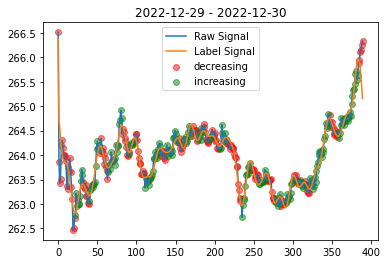

In [4]:
# read in data
data_df = pd.read_csv('./data/qqq_2022.csv')

# produce truth labels
print('Computing Label Space...')
label_df = labeller.driver(data_df, 21, 'Close')
print(label_df.head())

# plot data/labels/label signal
ps.plot_label_over_signal(data_df.iloc[-390:], label_df.iloc[-390:], 'Close')

#### Labelling Explanation

Stock Market data is very noisy, and is often likened to "random walks". Because of this, computing outright price differentials (price_t - price_t-1) will not result in coherent/noiseless data. So, some form of "truth" data must be computed.

In order to best classify the direction of the market's movement, the following process was conducted to compute "truth" data:

1. To account for growth, the coefficients of the following exponential function were optimized to the data:
$\newline$
$y = Ax^B + C$
$\newline$

2. To account for fluctuations around the exponential function, an FFT was computed on the following price values:
$\newline$
$clean\_signal = FFT(raw\_data - growth\_model)$
$\newline$

3. Produce a clean version of the market data:
$\newline$
$clean\_market\_signal = growth\_model + clean\_signal$
$\newline$

4. Compute Velocity of clean market data
$\newline$
$ velocity = \frac{\delta clean\_market\_signal}{\delta t}$
$\newline$

5. Compute Labels from Velocity
$\newline$
$ y = 0;\space velocity < 0 \newline$
$ y = 1;\space velocity > 0$

# ARIMA Assessment

# Neural Net Assessment

MLP Hyperparameter Configuration:
{'activation': 'softmax',
 'epochs': 3,
 'in_shape': 18,
 'loss': 'categorical_crossentropy',
 'metrics': ['accuracy'],
 'n_fft_components': 8,
 'out_shape': 2,
 'periods': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
 'signal_data_column': 'Close'}

Training MLP:
Epoch 1/3
2350/2350 [==============================] - 6s 2ms/step - loss: 0.5864 - accuracy: 0.6927
Epoch 2/3
2350/2350 [==============================] - 5s 2ms/step - loss: 0.5820 - accuracy: 0.6946
Epoch 3/3
588/588 [==============================] - 0s 722us/step

Test Space Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.71      0.69      9248
         1.0       0.70      0.68      0.69      9545

    accuracy                           0.69     18793
   macro avg       0.69      0.69      0.69     18793
weighted avg       0.69      0.69      0.69     18793



<module 'matplotlib.pyplot' from 'C:\\Users\\cwass\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

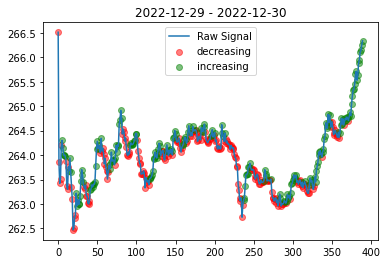

In [3]:
# use the default config file for building/training the Multilayer Perceptron
nn_config = nn_train_driver.default_training_config()
print(f'MLP Hyperparameter Configuration:')
pprint(nn_config)

# build/train the MLP
print('\nTraining MLP:')
model, test_df = nn_train_driver.train_mlp(data_df, label_df=label_df, config=nn_config)

# format the test df to just be the feature space
feature_cols = list(test_df.columns)
feature_cols.remove('EpochTime')
feature_cols.remove('Label')

# get the properly formatted test space
y_test_true = test_df['Label']
yhat_test = nn_train_driver.inverse_onehot(model.predict(test_df[feature_cols]))
print(f'\nTest Space Classification Report:\n{classification_report(y_test_true, yhat_test)}')

# plot the NN classifications on the last few days of data
yhat_test_df = pd.DataFrame({'EpochTime': test_df['EpochTime'].values,
                             'Label': yhat_test})
ps.plot_label_over_signal(data_df.iloc[-390:], yhat_test_df.iloc[-390:], 'Close')